In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 33394386.98it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 1067585.23it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 10807583.24it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



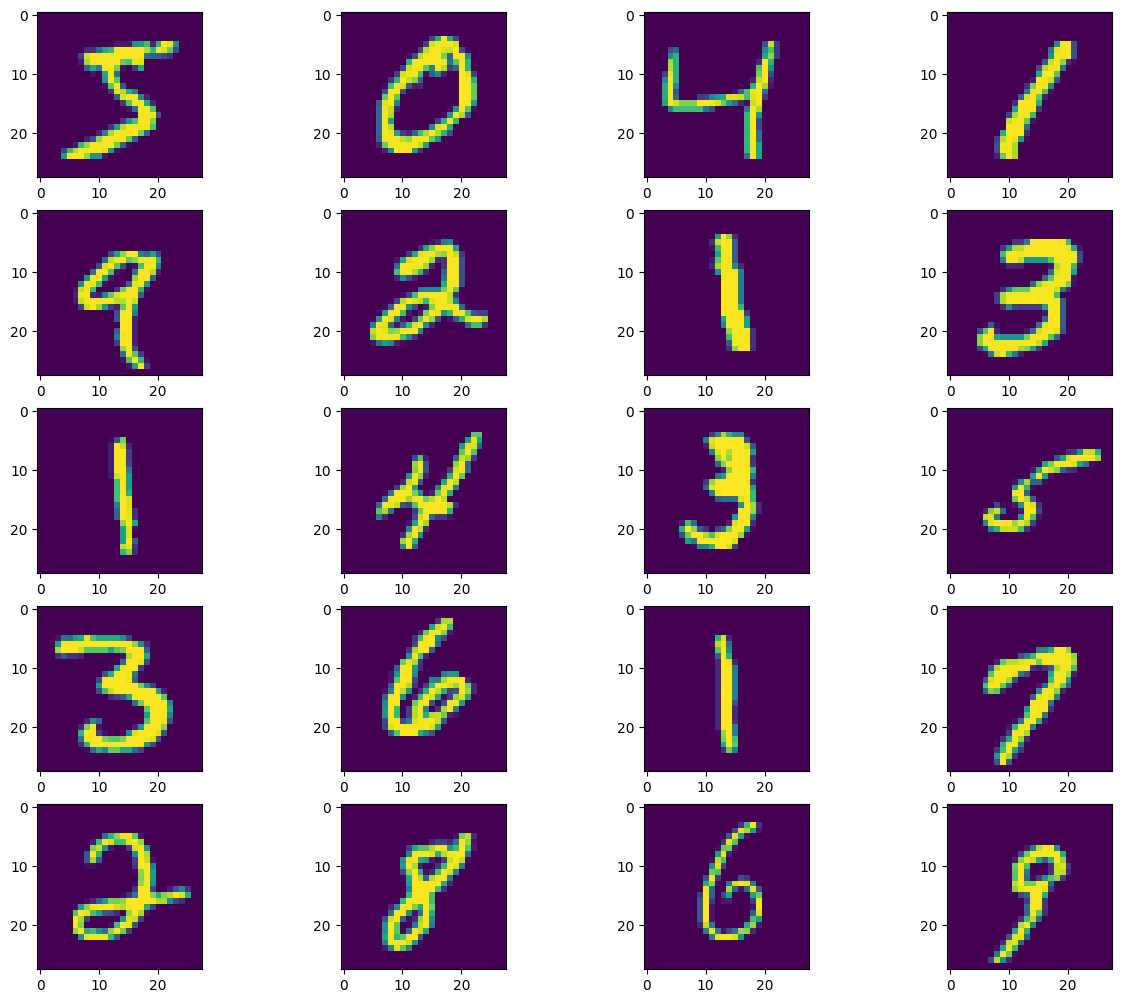

In [2]:
def show_images(daset, num_samples = 20, cols = 4):
    plt.figure(figsize = (15,15))
    for i, img in enumerate(data):
        if  i == num_samples:
            break
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.MNIST(root = ".", download = True)
show_images(data)

In [3]:
import torch.nn.functional as F

In [4]:
def linear_beta_schedule(timesteps, start = 0.0001, end = 0.02):
    """ 
    This function generates a linear schedule of noise levels (β) 
    over a given number of timesteps.
    """
    return torch.linspace(start, end, timesteps)
print(linear_beta_schedule(10))

tensor([1.0000e-04, 2.3111e-03, 4.5222e-03, 6.7333e-03, 8.9444e-03, 1.1156e-02,
        1.3367e-02, 1.5578e-02, 1.7789e-02, 2.0000e-02])


In [5]:
def get_index_from_list(vals, t, x_shape):
    """
    This function retrieves the noise values corresponding to the current timestep 't' 
    from a list of precomputed values 'vals'. It accounts for the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu()) # selects elemnts from vals based on indices t
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [6]:
def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    This function adds noise to the input data x_0 at a given timestep t, 
    simulating the forward process in the diffusion model
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape) #This term scales the original data x_0
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    ) # This term scales the noise
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)
    # The function returns the noisy version of x_0 for the current timestep and the noise added to it.

In [7]:
"""
Pre-computation of Terms
"""
T = 300
betas = linear_beta_schedule(timesteps = T) # The noise schedule generated using linear_beta_schedule.
alphas = 1. - betas # The values representing 1 - betas, which is used to calculate the cumulative product over timesteps.
alphas_cumprod = torch.cumprod(alphas, axis=0) #  The cumulative product of alphas across timesteps, used to control the amount of noise added.
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value = 1.0) # The cumulative product of alphas from the previous timestep, with padding to match dimensions.
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) # The square root of the reciprocal of alphas, which is part of the noising process.
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # The square root of the cumulative product of alphas, used to scale the original data.
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # The square root of 1 - alphas_cumprod, used to scale the noise.
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # The variance used in the posterior distribution, crucial for the denoising step in the diffusion process.

In [11]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)
    train = torchvision.datasets.MNIST(root = ".", download = True, transform = data_transform)
    subset_indices = torch.arange(12800)
    train = Subset(train, subset_indices)
    return train

def show_tensor_image(image):
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t : (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1,2,0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])

    if len(image.shape) == 4:
        image = image[0, :,:,:]
    return reverse_transform(image)

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [12]:
count = 0
for _ in dataloader:
    count += 1
print(count)

100


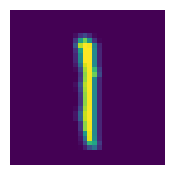

In [31]:
image = next(iter(dataloader))[0]
plt.figure(figsize = (2,3))
plt.axis('off')
show_tensor_image(image)
plt.imshow(show_tensor_image(image))

<Figure size 1500x1500 with 0 Axes>

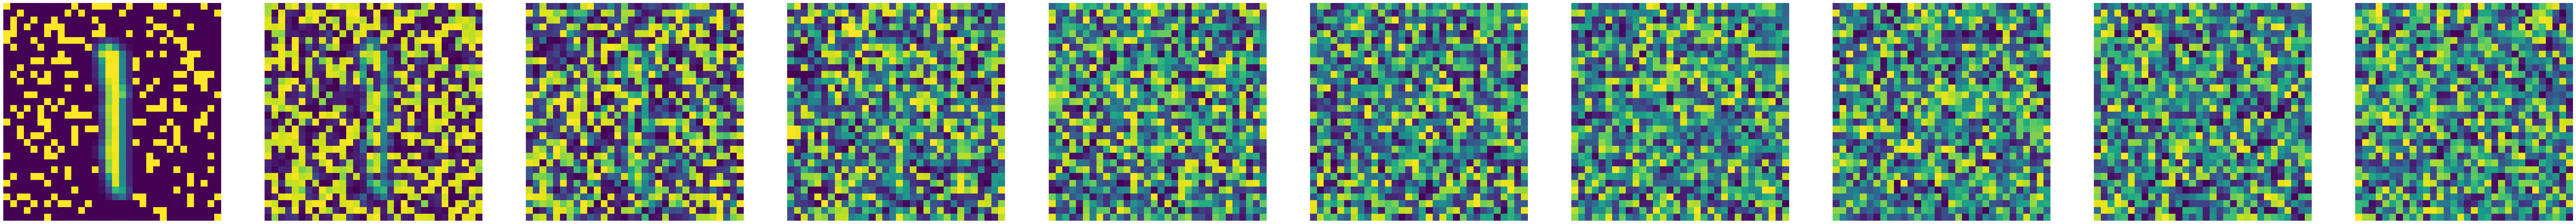

In [32]:
plt.figure(figsize = (15,15))
# plt.axis('off')
num_images = 10
f, ax = plt.subplots(1, num_images, figsize = (100,100))
stepsize = int(T / num_images)
plt_idx = 0
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    img, noise = forward_diffusion_sample(image, t)
    ax[plt_idx].imshow(show_tensor_image(img))
    ax[plt_idx].axis('off')
    plt_idx += 1
plt.show()

In [274]:
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up = False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding = 1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class PositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1) # Computes a constant factor used to scale the positional embeddings
        embeddings = torch.exp(torch.arange(half_dim, device = device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim = -1)
        return embeddings
        
class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64,128,256,512,1024)
        up_channels = (1024,512,256,128,64)
        out_dim = 1
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            PositionalEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding = 1)
        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_emb_dim)
            for i in range(len(down_channels) - 1)
        ])
        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i+1], time_emb_dim, up = True)
            for i in range(len(up_channels) - 1)
        ])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x,t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # print(x.shape, residual_x.shape)
            x = torch.cat((x, residual_x), dim = 1)
            x = up(x,t)
        return self.output(x)
        

In [275]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62437601


SimpleUnet(
  (time_mlp): Sequential(
    (0): PositionalEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2

In [276]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [277]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    img_size = IMG_SIZE
    img = torch.randn((1, 1, img_size, img_size), device = device)
    plt.figure(figsize = (15, 15))
    num_images = 10
    stepsize = int(T / num_images)
    f, ax = plt.subplots(1, num_images, figsize = (100, 100))
    ax_idx = 0

    for i in range(0, T)[::-1]:
        t = torch.full((1, ), i, device = device, dtype = torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            ax[ax_idx].imshow(show_tensor_image(img.detach().cpu()))
            ax[ax_idx].axis('off')
            ax_idx += 1
    plt.show()

Epoch 0 | step 000 Loss: 0.8123186826705933 
Epoch 0 | step 001 Loss: 0.6764053702354431 
Epoch 0 | step 002 Loss: 0.5753381848335266 
Epoch 0 | step 003 Loss: 0.4890713691711426 
Epoch 0 | step 004 Loss: 0.41594773530960083 
Epoch 0 | step 005 Loss: 0.4089301526546478 
Epoch 0 | step 006 Loss: 0.43783101439476013 
Epoch 0 | step 007 Loss: 0.4099496304988861 
Epoch 0 | step 008 Loss: 0.3829246759414673 
Epoch 0 | step 009 Loss: 0.3718016743659973 
Epoch 0 | step 010 Loss: 0.3617252707481384 
Epoch 0 | step 011 Loss: 0.3431050181388855 
Epoch 0 | step 012 Loss: 0.3525012135505676 
Epoch 0 | step 013 Loss: 0.33395522832870483 
Epoch 0 | step 014 Loss: 0.32754191756248474 
Epoch 0 | step 015 Loss: 0.32193470001220703 
Epoch 0 | step 016 Loss: 0.3202556371688843 
Epoch 0 | step 017 Loss: 0.3125433921813965 
Epoch 0 | step 018 Loss: 0.29623520374298096 
Epoch 0 | step 019 Loss: 0.29920434951782227 
Epoch 0 | step 020 Loss: 0.30121564865112305 
Epoch 0 | step 021 Loss: 0.28839385509490967 
E

C:\Users\oswme\AppData\Local\Temp\ipykernel_38188\2450842313.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i / stepsize) + 1)


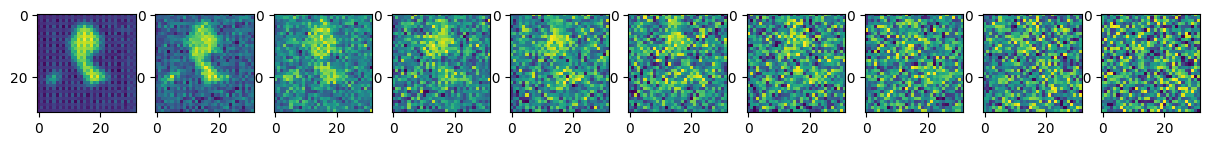

In [278]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 1 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        if epoch % 5 == 0 and step == 99:
            sample_plot_image()